In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you put all the files under MLSP24_HW2 folder in myDrive, then it should be 'MLSP24_HW2'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'BERT'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
output_path = os.path.join(GOOGLE_DRIVE_PATH, 'output')
logs_path = os.path.join(GOOGLE_DRIVE_PATH, 'logs')
os.makedirs(output_path, exist_ok=True)
os.makedirs(logs_path, exist_ok=True)
print(os.listdir(GOOGLE_DRIVE_PATH))

['output', 'logs', 'bert.ipynb']


In [4]:
!pip install datasets
!pip install accelerate -U
!pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none

In [6]:
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import TrainingArguments, Trainer
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")
train_data = dataset['train']
validation_df = dataset['validation']
train_panda_df = train_data.to_pandas()
train_df, test_df = train_test_split(train_panda_df, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

def tokenizer_function(examples):
    return tokenizer(examples['text'], max_length=128, padding="max_length", truncation=True)

train_token = train_df.map(tokenizer_function, batched=True)
validation_token = validation_df.map(tokenizer_function, batched=True)
test_token = test_df.map(tokenizer_function, batched=True)
batch_size = 32

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [8]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
logging_steps = len(train_token) // batch_size
training_args = TrainingArguments(
    output_dir=output_path,
    learning_rate=3e-5,
    num_train_epochs=5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=300,
    weight_decay=0.02,
    logging_dir=logs_path,
    logging_steps=logging_steps,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model='accuracy'
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_token,
    eval_dataset=validation_token,
    compute_metrics=compute_metrics
)

In [11]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.741400,0.417957,0.846734,0.844109,0.843800,0.846734
2,0.369200,0.331052,0.880653,0.879751,0.879333,0.880653
3,0.188700,0.383319,0.882747,0.882439,0.883078,0.882747
4,0.087800,0.481197,0.881910,0.882449,0.883209,0.881910
5,0.038500,0.537347,0.881072,0.881061,0.881418,0.881072


TrainOutput(global_step=1195, training_loss=0.28400798925670123, metrics={'train_runtime': 912.8042, 'train_samples_per_second': 41.816, 'train_steps_per_second': 1.309, 'total_flos': 2510759788669440.0, 'train_loss': 0.28400798925670123, 'epoch': 5.0})

In [12]:
model_path = os.path.join(GOOGLE_DRIVE_PATH, 'model')
os.makedirs(model_path, exist_ok=True)
model.save_pretrained(model_path)

In [13]:
labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
def plot_confusion_matrix(y_preds, y_true, labels_dict):
  labels = [labels_dict[i] for i in range(len(labels_dict))]
  cm = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion matrix')
  return fig, ax

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

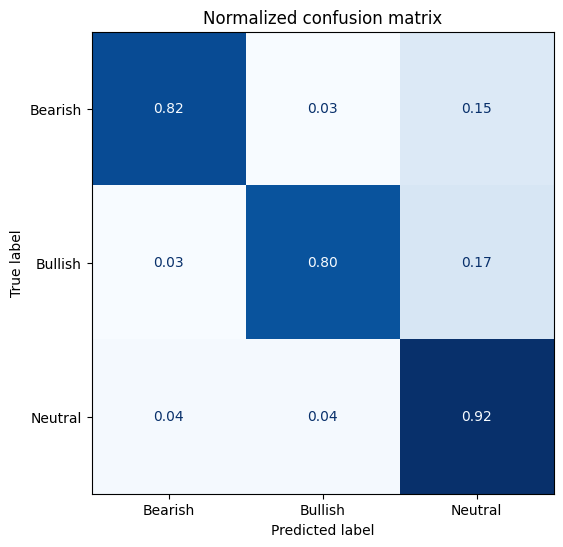

In [15]:
preds_output = trainer.predict(validation_token)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = validation_token['label']
plot_confusion_matrix(y_preds, y_true, labels)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>)

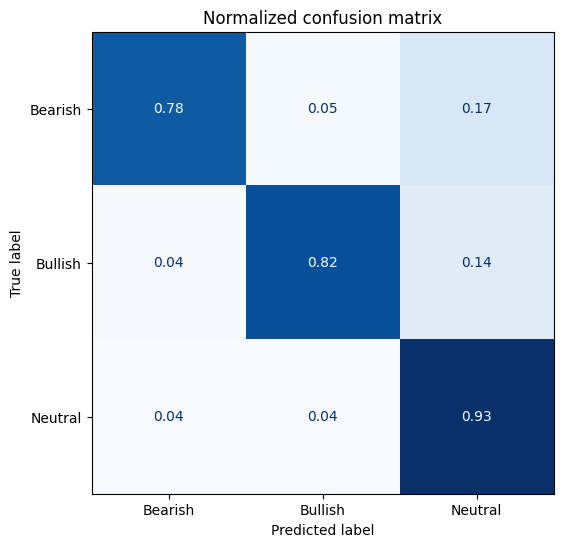

In [14]:
preds_output = trainer.predict(test_token)
y_preds = np.argmax(preds_output.predictions, axis=-1)
y_true = test_token['label']
plot_confusion_matrix(y_preds, y_true, labels)

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

report = classification_report(y_true, y_preds, target_names=list(labels.values()))
print(report)

              precision    recall  f1-score   support

     Bearish       0.78      0.82      0.80       347
     Bullish       0.84      0.80      0.82       475
     Neutral       0.92      0.92      0.92      1566

    accuracy                           0.88      2388
   macro avg       0.85      0.85      0.85      2388
weighted avg       0.88      0.88      0.88      2388

